In [134]:
%matplotlib inline

import csv

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import mne
import seaborn as sns

from fooof.utils.download import load_fooof_data
from pathlib import Path
from fooof import FOOOFGroup
from fooof import FOOOF

from spiketools.plts.utils import make_axes


In [132]:
# Import custom project code
import sys
sys.path.append('/home/b1044271/bratios')
from utils import print_stat, print_stats
from bootstrap import bootstrap_corr, bootstrap_diff
from settings import RATIO_NAMES, BAND_NAMES
from plot import plot_param_topo, plot_param_ratio_corr
from paths import DATA_PATHS as dp
from paths import FIGS_PATHS as fp

sys.path.append('/home/b1044271/Columbia/helper_scripts')
from plot_columbia2 import plot_hd_topo

In [4]:
# E137: Oz, E110: Pz, E21: Fz, E257: Cz
# get the staging list
path_stage = Path('/home/b1044271/EEGsleep/SleepStaging/mat/mne2/')
stage_files = os.listdir(path_stage)
stage_files = [file for file in stage_files]
stage_files = sorted(stage_files)

stages = ['N1','N2','N3','RM','AW']

In [5]:
# get the subjects list
Data_path = '/home/b1044271/Columbia/Preprocessed/Better_ica/'
subj_files = os.listdir(Data_path)
subj_files = [file for file in subj_files]
subj_files = sorted(subj_files)


In [6]:
# Settings for the PSD calac
fs = 250
SETTINGS_B = { 'method' : 'welch', 'average' : 'mean', 'fmin' :1 , 'fmax': 45, 'n_fft':fs*5}
path_results = Path('/home/b1044271/Columbia/Results/PSDs')
path_frqs = Path('/home/b1044271/Columbia/Results/PSDs/Freqs')

In [7]:
SETTINGS_F1={'max_n_peaks':8, 'aperiodic_mode':'fixed'}
SETTINGS_F2={'max_n_peaks':8, 'aperiodic_mode':'knee'}

fm1 = FOOOFGroup(**SETTINGS_F1)
fm2 = FOOOFGroup(**SETTINGS_F2)

In [8]:
i = 0

EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, subj_files[0]), preload = True) # read raw .set file


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3396550/3279727134.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, subj_files[0]), preload = True) # read raw .set file


['E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'E9',
 'E10',
 'E11',
 'E12',
 'E13',
 'E14',
 'E15',
 'E16',
 'E17',
 'E18',
 'E19',
 'E20',
 'E21',
 'E22',
 'E23',
 'E24',
 'E25',
 'E26',
 'E27',
 'E28',
 'E29',
 'E30',
 'E32',
 'E33',
 'E34',
 'E35',
 'E36',
 'E37',
 'E38',
 'E39',
 'E40',
 'E41',
 'E42',
 'E43',
 'E44',
 'E45',
 'E46',
 'E47',
 'E48',
 'E49',
 'E50',
 'E51',
 'E52',
 'E53',
 'E54',
 'E55',
 'E56',
 'E57',
 'E58',
 'E59',
 'E60',
 'E61',
 'E62',
 'E63',
 'E64',
 'E65',
 'E66',
 'E68',
 'E69',
 'E70',
 'E71',
 'E72',
 'E74',
 'E75',
 'E76',
 'E77',
 'E78',
 'E79',
 'E80',
 'E81',
 'E83',
 'E84',
 'E85',
 'E86',
 'E87',
 'E88',
 'E89',
 'E90',
 'E94',
 'E95',
 'E96',
 'E97',
 'E98',
 'E99',
 'E100',
 'E101',
 'E105',
 'E106',
 'E107',
 'E108',
 'E109',
 'E110',
 'E114',
 'E115',
 'E116',
 'E117',
 'E118',
 'E119',
 'E123',
 'E124',
 'E125',
 'E126',
 'E127',
 'E128',
 'E129',
 'E130',
 'E131',
 'E132',
 'E136',
 'E137',
 'E138',
 'E139',
 'E140',
 'E141',
 'E

In [145]:
np.arange(EEG._first_time,   EEG._last_time-2,1)

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 2.7761e+04, 2.7762e+04,
       2.7763e+04])

In [144]:
EEG._last_time

27764.804

In [139]:
EEG.__dict__

{'_data': array([[-5.58401838e-05, -7.40891327e-05, -5.42127119e-05, ...,
          6.19184876e-05,  7.25513073e-05,  3.60452862e-05],
        [-2.91399500e-04, -3.81324820e-04, -3.37658321e-04, ...,
         -1.54180815e-05, -1.21683676e-06,  1.09731719e-05],
        [-2.89962206e-04, -4.03397722e-04, -3.40211126e-04, ...,
         -8.04625349e-05, -6.93356169e-05,  8.08382364e-07],
        ...,
        [-2.56184239e-04, -3.11233092e-04, -2.80417271e-04, ...,
         -9.69348632e-06,  2.03012782e-06, -1.78401025e-05],
        [-2.68452894e-04, -3.20493802e-04, -3.00678167e-04, ...,
         -1.94919239e-05, -1.36359259e-05, -1.34799208e-05],
        [ 1.21319740e-06,  4.32915489e-05,  2.30004062e-05, ...,
          4.65990214e-05,  5.53900631e-05, -1.01611062e-06]]),
 'preload': True,
 '_last_samps': array([6941201]),
 '_first_samps': array([0]),
 'info': <Info | 8 non-empty values
  bads: []
  ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
  chs: 183 EEG


In [9]:
montage = mne.channels.make_standard_montage('GSN-HydroCel-257')
montage.ch_names[-1] = 'E257'
info    = mne.create_info(EEG.ch_names, fs, 'eeg')

['E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'E9',
 'E10',
 'E11',
 'E12',
 'E13',
 'E14',
 'E15',
 'E16',
 'E17',
 'E18',
 'E19',
 'E20',
 'E21',
 'E22',
 'E23',
 'E24',
 'E25',
 'E26',
 'E27',
 'E28',
 'E29',
 'E30',
 'E32',
 'E33',
 'E34',
 'E35',
 'E36',
 'E37',
 'E38',
 'E39',
 'E40',
 'E41',
 'E42',
 'E43',
 'E44',
 'E45',
 'E46',
 'E47',
 'E48',
 'E49',
 'E50',
 'E51',
 'E52',
 'E53',
 'E54',
 'E55',
 'E56',
 'E57',
 'E58',
 'E59',
 'E60',
 'E61',
 'E62',
 'E63',
 'E64',
 'E65',
 'E66',
 'E68',
 'E69',
 'E70',
 'E71',
 'E72',
 'E74',
 'E75',
 'E76',
 'E77',
 'E78',
 'E79',
 'E80',
 'E81',
 'E83',
 'E84',
 'E85',
 'E86',
 'E87',
 'E88',
 'E89',
 'E90',
 'E94',
 'E95',
 'E96',
 'E97',
 'E98',
 'E99',
 'E100',
 'E101',
 'E105',
 'E106',
 'E107',
 'E108',
 'E109',
 'E110',
 'E114',
 'E115',
 'E116',
 'E117',
 'E118',
 'E119',
 'E123',
 'E124',
 'E125',
 'E126',
 'E127',
 'E128',
 'E129',
 'E130',
 'E131',
 'E132',
 'E136',
 'E137',
 'E138',
 'E139',
 'E140',
 'E141',
 'E

In [21]:
events = mne.read_events(Path(path_stage, stage_files[0])) #read staging markers
epochs = mne.Epochs(EEG, events=events, tmin=-30, tmax=0)
i = i+1

N1s = epochs['1']
N2s = epochs['2']
N3s = epochs['3']
REs = epochs['5']
AWs = epochs['0']

# Settings for PSD calculation using welch's
N1={}
N2={}
N3={}
AW={}
RM={}

N1 = N1s.compute_psd(**SETTINGS_B) #calculate psd over 5s widnow , range 1 -45Hz
N2 = N2s.compute_psd(**SETTINGS_B) #N2
N3 = N3s.compute_psd(**SETTINGS_B)
AW = AWs.compute_psd(**SETTINGS_B)
RM = REs.compute_psd(**SETTINGS_B)

Not setting metadata
927 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 85 events and 7501 original time points ...


/tmp/ipykernel_3396550/396503694.py:1: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP01_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[0])) #read staging markers


0 bad epochs dropped
Effective window size : 5.000 (s)
Using data from preloaded Raw for 465 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)
Using data from preloaded Raw for 140 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)
Using data from preloaded Raw for 75 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 5.000 (s)
Using data from preloaded Raw for 161 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 5.000 (s)


In [84]:

epoch_no = min([len(N1._data),len(N2._data),len(N3._data),len(AW._data),len(RM._data)])

N1n = N1._data[sorted(np.random.choice(len(N1._data), size=epoch_no, replace=False))]
N2n = N2._data[sorted(np.random.choice(len(N2._data), size=epoch_no, replace=False))]
N3n = N3._data[sorted(np.random.choice(len(N3._data), size=epoch_no, replace=False))]
RMn = RM._data[sorted(np.random.choice(len(RM._data), size=epoch_no, replace=False))]
AWn = AW._data[sorted(np.random.choice(len(AW._data), size=epoch_no, replace=False))]

PSD_Data = [N1n,N2n,N3n,RMn,AWn]

In [85]:
SL_NK=np.ones([len(PSD_Data),len(EEG.ch_names)]) * np.nan
R2_NK=np.ones([len(PSD_Data),len(EEG.ch_names)]) * np.nan
SL_K=np.ones([len(PSD_Data),len(EEG.ch_names)]) * np.nan
R2_K=np.ones([len(PSD_Data),len(EEG.ch_names)]) * np.nan
KN_K=np.ones([len(PSD_Data),len(EEG.ch_names)]) * np.nan

i = 0
for S in PSD_Data: 
    fm1.fit(N1._freqs, np.mean(S, axis = 0), [N1._freqs[0] , N1._freqs[-1]])
    SL_NK[i,0:183] = fm1.get_params('aperiodic_params','exponent')
    R2_NK[i,0:183]  = fm1.get_params('r_squared')
    

    fm2.fit(N1._freqs, np.mean(S, axis = 0), [N1._freqs[0] , N1._freqs[-1]])
    SL_K[i,0:183]  = fm2.get_params('aperiodic_params','exponent')
    KN_K[i,0:183]   = fm2.get_params('aperiodic_params','knee')
    R2_K[i,0:183] = fm2.get_params('r_squared')
    
    i = i+1

Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.

In [17]:
raw = mne.io.RawArray(np.zeros([len(EEG.ch_names), 1]), info, verbose=False)
raw = raw.set_montage(montage)

/home/b1044271/plot.py:128: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  mne.viz.plot_topomap(data, raw.info, vmin=min(data), vmax=max(data),


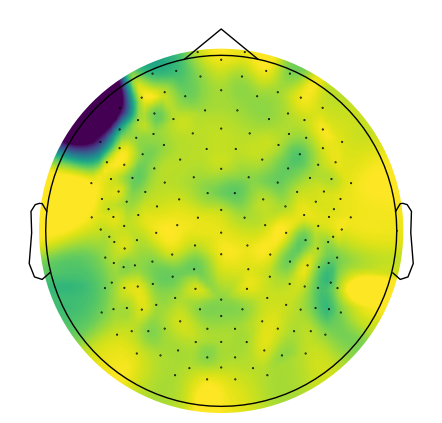

In [43]:
plot_param_topo(R2_K, raw, 'Ratio-TAR')


/home/b1044271/plot.py:128: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  mne.viz.plot_topomap(data, raw.info, vmin=min(data), vmax=max(data),


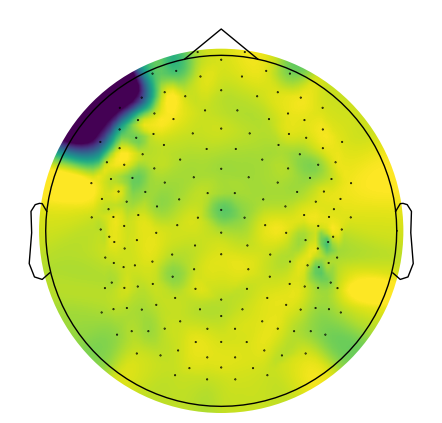

In [44]:
plot_param_topo(R2_NK, raw, 'Ratio-TAR')


AttributeError: 'numpy.ndarray' object has no attribute 'get_yticks'

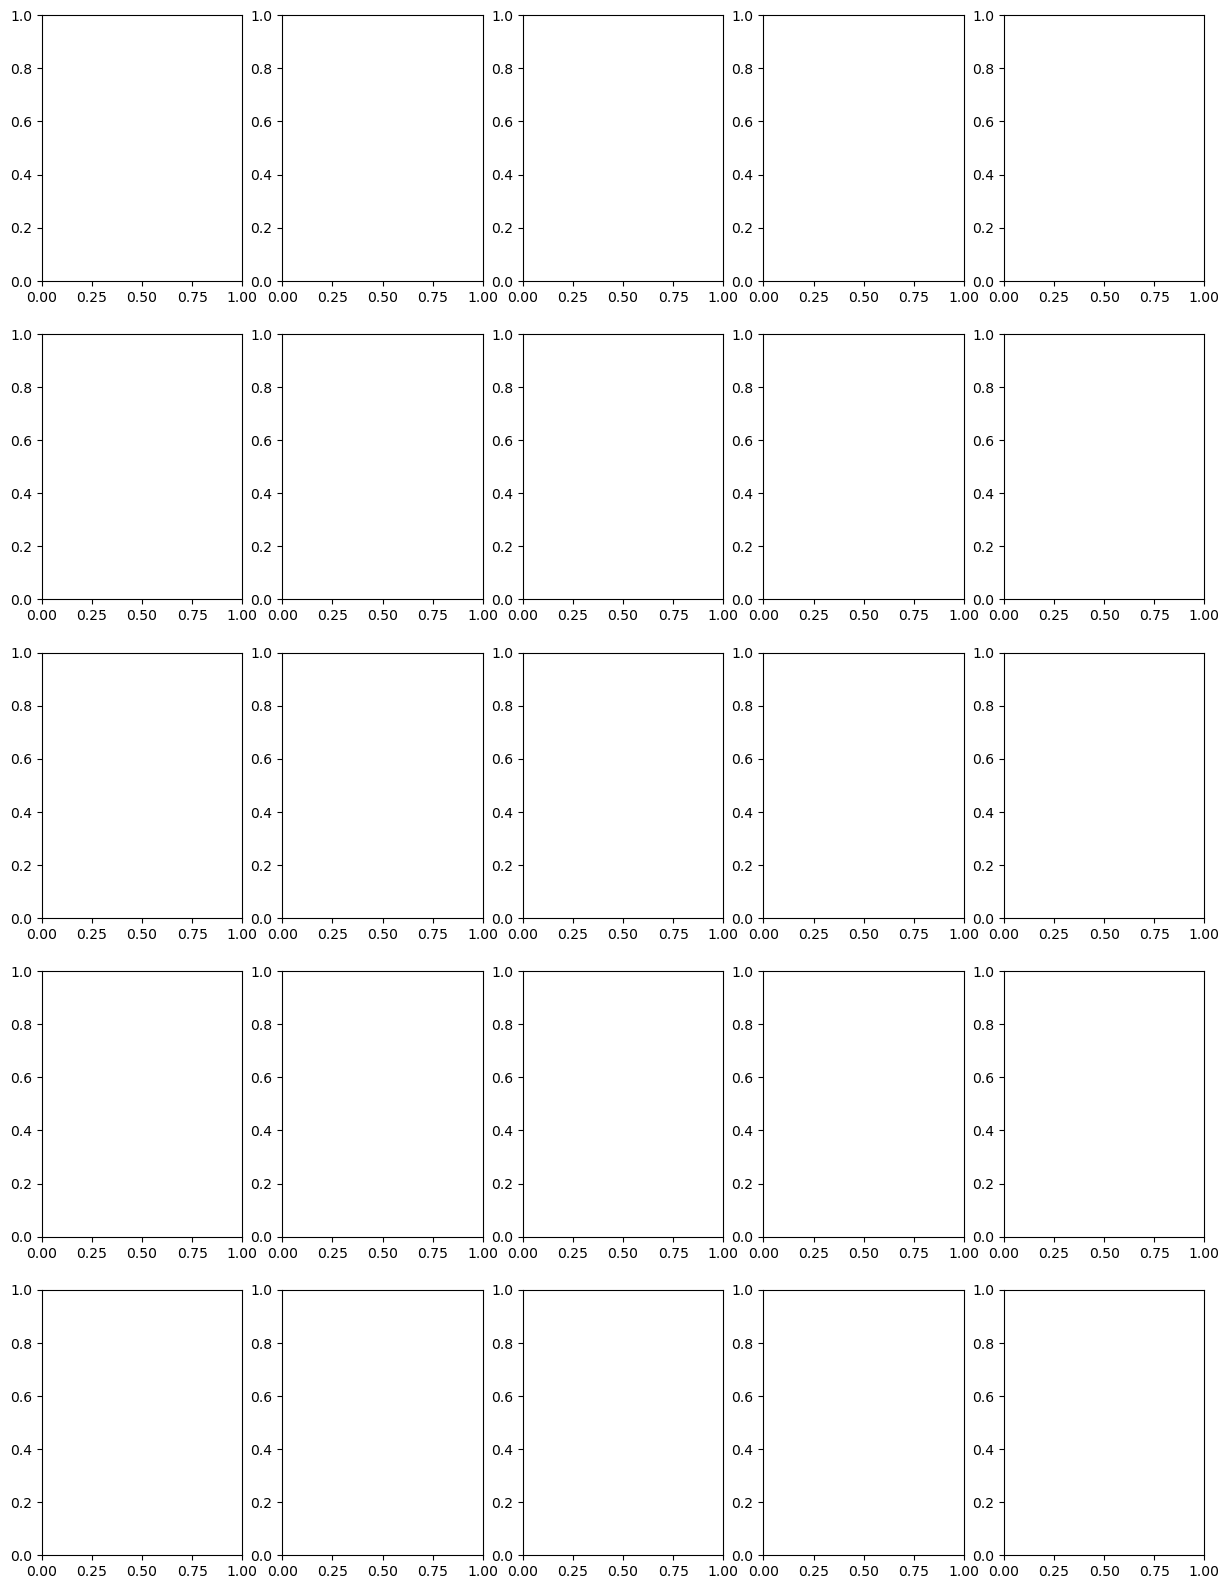

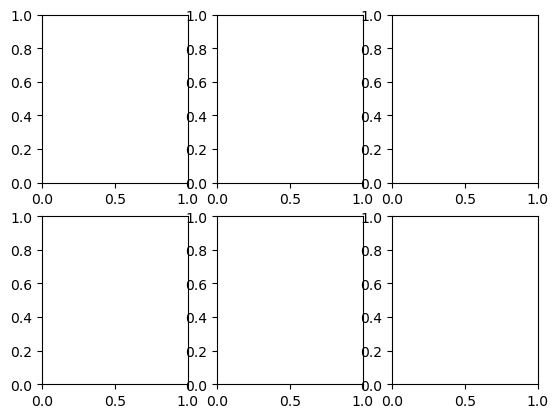

In [138]:
ax = iter(make_axes(25, 5, figsize=(15, 20)))

fig, ax = plt.subplots(2,3)
for i in range(5):
    
    mne.viz.plot_topomap(data = SL_NK[i], pos = raw.info, vlim=(0,1), axes = next(ax))
    plot_hd_topo(R2_NK[i], raw, 0,1, next(axes))
    plot_hd_topo(SL_K[i], raw, 0,1, next(axes))
    plot_hd_topo(R2_K[i], raw, 'Ratio-TAR', ax=next(axes))
    plot_hd_topo(KN_K[i], raw, 'Ratio-TAR', ax=next(axes))



In [137]:
next(ax)

TypeError: 'numpy.ndarray' object is not an iterator

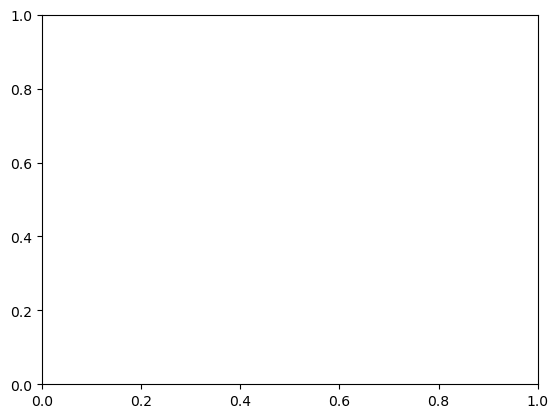

In [126]:
fig, ax = plt.subplots();

In [136]:
ax

array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

In [128]:
ax

<AxesSubplot: >

In [117]:
ax

array([[<AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

In [92]:
make_axes?

In [88]:
i =1
np.shape(SL_NK[i])

(183,)